In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def stampToTime(x):
    l = x.split(' ')[1]
    ts = l.split(':')
    t = float(ts[0])*3600 + float(ts[1])*60 + float(ts[2])
    return t

72.10623605873322


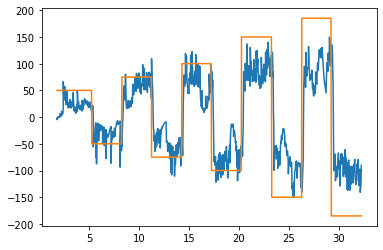

In [164]:
def cut_window(gs,vys,ts):
    
    start_t = 0
    for g,t in zip(gs,ts): 
        if g == -50: 
            start_t = t - 3.5
            break
            
    ng = []; nvy = []; nt = []
    for i,[g,vy,t] in enumerate(zip(gs,vys,ts)):
        if t > start_t + 3.5 and g == 50: break
        if t > start_t: ng.append(g); nvy.append(vy); nt.append(t)
            
    return ng,nvy,nt

def norm_time(data):
    data["timestamp"] = data["timestamp"].apply(lambda x: stampToTime(x))
    data["timestamp"] = data["timestamp"] - data.iloc[0]["timestamp"]
    return data

def getVy(data):
    vys = []; ts = []; e = []; gs = []
    for y, ym, t, tm, g in zip(data[" y"][1:],\
                            data[" y"][0:-1],\
                            data["timestamp"][1:],\
                            data["timestamp"][0:-1],\
                            data[" goalVy"][1:]):
        dy = float(y)-float(ym)
        dt = float(t)-float(tm)
        if dt > 0 and abs(dy/dt) < 185 and g != 0:
            ts.append(t)
            if len(vys) != 0: vys.append(0.5*vys[-1] + 0.5*dy/dt)
            else: vys.append(dy/dt)
            e.append(abs(vys[-1]-float(g)))
            gs.append(float(g))
    return ts,vys,e,gs
    
data = pd.read_csv(file + files[0] + ".csv")
data = data[data[" weight"] == "100"]
data = data[data[" run#"] == "1"]
print(process_error(data))
data = norm_time(data)
t,vy,e,g = getVy(data)
g,vy,t = cut_window(g,vy,t)
plt.plot(t,vy)
plt.plot(t,g)

In [278]:
def process_error(data):
    data = norm_time(data.copy())
    t,vy,e,g = getVy(data)
    gs,vys,t = cut_window(g,vy,t)
    es = []
    for g,vy in zip(gs,vys):
        es.append(pow(g-vy,2))
    
    s = []
    for v in [50,75,100,150,185]:
        w = []
        for g,e in zip(gs,es):
            if abs(g) == v: w.append(e)
        if len(w)==0:s.append(-1)
        else:s.append(np.mean(w))
            
    return s

In [280]:
def clean_ctrl(s): 
    if s.strip() not in ["old","adaptive"]: return "adaptive"
    else: return s.strip()
    
def clean_run(s):
    if type(s) == int: return s
    if s.strip() not in ["1","2","3"]: return "nan"
    else: return int(s.strip())
    
def clean_weight(s):
    if type(s) == int: return s
    if s.strip() not in ["0","50","100","150","200"]: return "nan"
    else: return int(s.strip())

file = "logs_Ubuntu_20.04.3_LTS_@_A0_A4_C5_91_5E_9B_Thu-17-02-2022_"
files = ["13_14_09","13_45_59","14_02_52","14_14_20",\
         "15_04_54","15_39_07","15_39_07[1]","15_45_05"]

df = pd.DataFrame(columns=["Ctrl","Weight","Run","Err 50","Err 75","Err 100","Err 150","Err 185"])

for f in files:
    
    data = pd.read_csv(file + f + ".csv")
    ctrl = ""
    run = 0
    weight = 0
    err = 0
    
    data[" controller"] = data[" controller"].apply(lambda x: clean_ctrl(x))
    data[" run#"] = data[" run#"].apply(lambda x: clean_run(x))
    data.drop(data[data[" run#"]=="nan"].index,inplace=True)
    data[" weight"] = data[" weight"].apply(lambda x: clean_weight(x))
    data.drop(data[data[" weight"]=="nan"].index,inplace=True)
    
    for c in data[" controller"].unique():
        if c.strip() == "old": ctrl = "Old"
        else: ctrl = "Adaptive"
            
        data_c = data[data[" controller"] == c]
        
        for w in data_c[" weight"].unique():
            weight = w
            
            data_w = data_c[data_c[" weight"] == w]
                
            for r in data_w[" run#"].unique():
                run = r
                
                data_r = data_w[data_w[" run#"] == r]
                
                err = process_error(data_r)
                
                #print(f,c,w,r,err)
                if err[4] == -1:continue
                df = df.append({"Ctrl":c,"Weight":w,"Run":r,"Err 50":err[0],"Err 75":err[1],\
                                "Err 100":err[2],"Err 150":err[3],"Err 185":err[4]}, ignore_index=True)
df

,Ctrl,Weight,Run,Err 50,Err 75,Err 100,Err 150,Err 185
0,adaptive,0,1,852.265697,1869.483642,3808.119418,6475.651612,13439.495780
1,adaptive,0,2,965.145668,997.785635,3030.301104,5703.509874,11273.120948
2,adaptive,0,3,828.380538,1033.651525,2551.551026,8012.521097,18968.594323
3,adaptive,50,3,1040.245327,1781.005247,2332.835398,5856.678391,9506.642222
4,adaptive,50,1,866.904928,1155.457102,2119.999873,5453.189717,8199.270872
...,...,...,...,...,...,...,...,...
79,adaptive,150,2,672.027428,2462.669770,3288.331344,13942.309158,18844.932774
80,adaptive,150,3,1034.300608,2553.541591,4623.176425,10595.497300,16013.585879
81,adaptive,200,1,1304.309049,2826.701772,5556.265210,11182.785577,27109.886031
82,adaptive,200,2,1112.932199,2202.040261,5247.638443,15175.517830,21029.806456


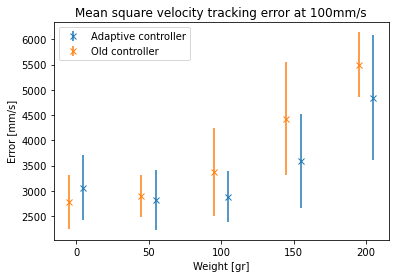

In [303]:
speeds = [50,75,100,150,185]
s = 2

ada = np.zeros(5)
ada_std = np.zeros(5)
df_ada = df[df["Ctrl"] == "adaptive"]
for i,w in enumerate([0,50,100,150,200]):
    df_ada_w = df_ada[df_ada["Weight"] == w]
    ada[i] = np.mean(df_ada_w["Err "+str(speeds[s])])
    ada_std[i] = np.std(df_ada_w["Err "+str(speeds[s])])
    
old = np.zeros(5)
old_std = np.zeros(5)
df_old = df[df["Ctrl"] == "old"]
for i,w in enumerate([0,50,100,150,200]):
    df_old_w = df_old[df_old["Weight"] == w]
    old[i] = np.mean(df_old_w["Err "+str(speeds[s])])
    old_std[i] = np.std(df_old_w["Err "+str(speeds[s])])

plt.errorbar([5,55,105,155,205],ada,ada_std,linestyle='None', marker='x', label="Adaptive controller")
plt.errorbar([-5,45,95,145,195],old,old_std,linestyle='None', marker='x', label="Old controller")
plt.title("Mean square velocity tracking error at "+str(speeds[s])+"mm/s")
plt.legend(loc = "upper left")
plt.xlabel("Weight [gr]")
plt.ylabel("Error [mm/s]")

plt.savefig('Tracking error.jpg',bbox_inches='tight', dpi=200)

plt.show()